In [2]:
!pip install pdpbox
!pip install shap
!pip install lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b50191d9e1c0563399fd08f8e05494face38b045171deaded2c981cf4479daf8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, partial_dependence
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt


In [16]:

import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                            precision_recall_curve, average_precision_score, roc_curve)
from sklearn.calibration import calibration_curve

from pdpbox import pdp, info_plots
import itertools
from scipy import stats

In [4]:
# Load preprocessed data
data = pd.read_csv('preprocessed_data.csv')  # From Data_Preprocessing.ipynb
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

In [14]:
gnb = GaussianNB()
param_grid_gnb = {
    'var_smoothing': np.logspace(-9, -5, 5)  # Smoothing parameter
}
grid_search_gnb = GridSearchCV(gnb, param_grid_gnb, cv=3, scoring='roc_auc')
grid_search_gnb.fit(X_train_scaled, y_train)

print("Gaussian Naive Bayes - Best parameters:", grid_search_gnb.best_params_)
best_gnb = grid_search_gnb.best_estimator_

Gaussian Naive Bayes - Best parameters: {'var_smoothing': np.float64(1e-09)}


In [17]:
# 2. Bernoulli Naive Bayes (assumes binary features)
bnb = BernoulliNB()
param_grid_bnb = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Smoothing parameter
    'binarize': [0.0, 0.25, 0.5, 0.75]  # Threshold for binarization
}
grid_search_bnb = GridSearchCV(bnb, param_grid_bnb, cv=3, scoring='roc_auc')
grid_search_bnb.fit(X_train_scaled, y_train)

print("Bernoulli Naive Bayes - Best parameters:", grid_search_bnb.best_params_)
best_bnb = grid_search_bnb.best_estimator_


Bernoulli Naive Bayes - Best parameters: {'alpha': 0.1, 'binarize': 0.0}


In [18]:
# Compare models and select the better one
gnb_auc = roc_auc_score(y_test, best_gnb.predict_proba(X_test_scaled)[:, 1])
bnb_auc = roc_auc_score(y_test, best_bnb.predict_proba(X_test_scaled)[:, 1])

print(f"Gaussian NB AUC: {gnb_auc:.4f}")
print(f"Bernoulli NB AUC: {bnb_auc:.4f}")


Gaussian NB AUC: 0.7907
Bernoulli NB AUC: 0.8418


In [19]:
# Select the better model
if gnb_auc >= bnb_auc:
    best_model = best_gnb
    model_name = "Gaussian Naive Bayes"
    print("Selected model: Gaussian Naive Bayes")
else:
    best_model = best_bnb
    model_name = "Bernoulli Naive Bayes"
    print("Selected model: Bernoulli Naive Bayes")

# Predictions with the best model
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

Selected model: Bernoulli Naive Bayes


In [20]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      9336
           1       0.32      0.59      0.41       664

    accuracy                           0.89     10000
   macro avg       0.64      0.75      0.67     10000
weighted avg       0.93      0.89      0.90     10000

ROC AUC Score: 0.8418285126366647
Confusion Matrix:
 [[8493  843]
 [ 275  389]]


In [6]:
# Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      9336
           1       0.28      0.04      0.07       664

    accuracy                           0.93     10000
   macro avg       0.61      0.52      0.52     10000
weighted avg       0.89      0.93      0.90     10000

ROC AUC Score: 0.7857108059487308
Confusion Matrix:
 [[9265   71]
 [ 637   27]]


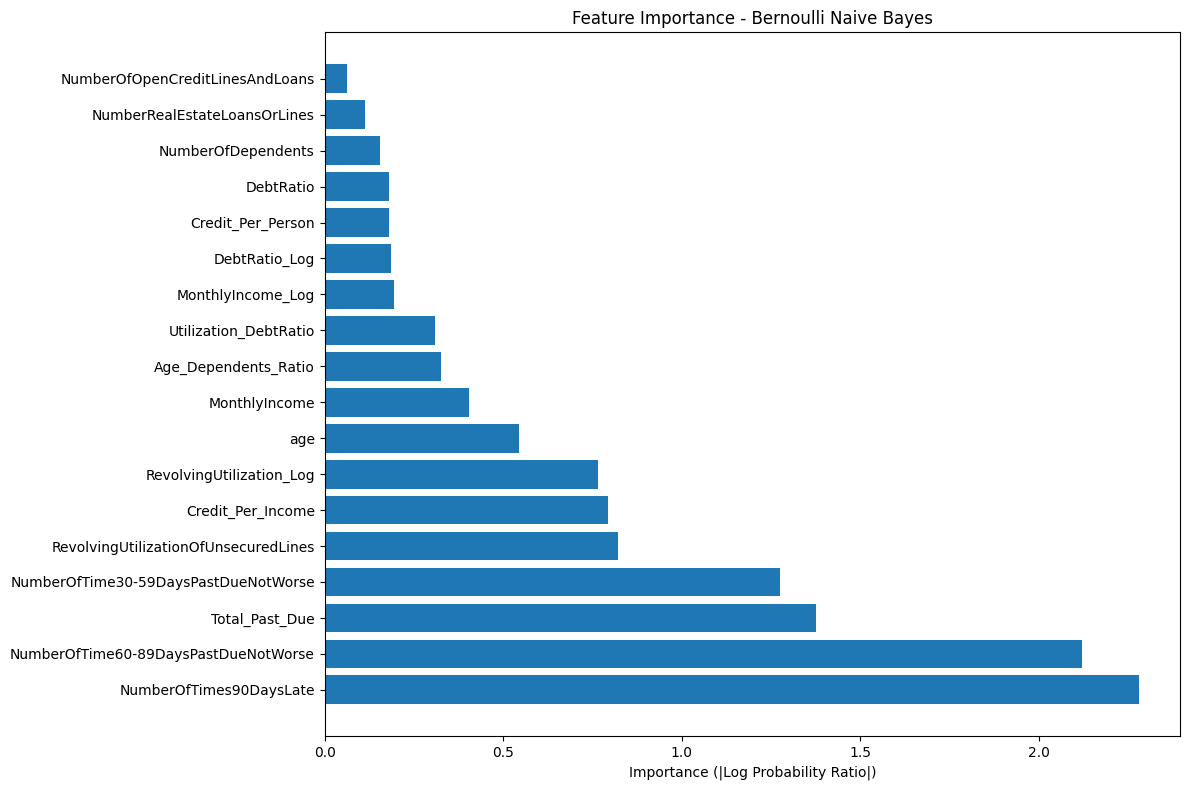

In [27]:
# 1. Feature Importance Analysis for Naive Bayes
if isinstance(best_model, GaussianNB):
    means_pos = best_model.theta_[1]
    means_neg = best_model.theta_[0]

    var = best_model.var_


    importance = np.abs(means_pos - means_neg) / np.sqrt(var.mean(axis=0))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importance
    })

    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance (|Mean Difference| / Std)')
    plt.title('Feature Importance - Gaussian Naive Bayes')
    plt.tight_layout()
    plt.show()

elif isinstance(best_model, BernoulliNB):

    log_prob_pos = best_model.feature_log_prob_[1]
    log_prob_neg = best_model.feature_log_prob_[0]

    importance = np.abs(log_prob_pos - log_prob_neg)

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importance
    })

    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance (|Log Probability Ratio|)')
    plt.title('Feature Importance - Bernoulli Naive Bayes')
    plt.tight_layout()
    plt.show()

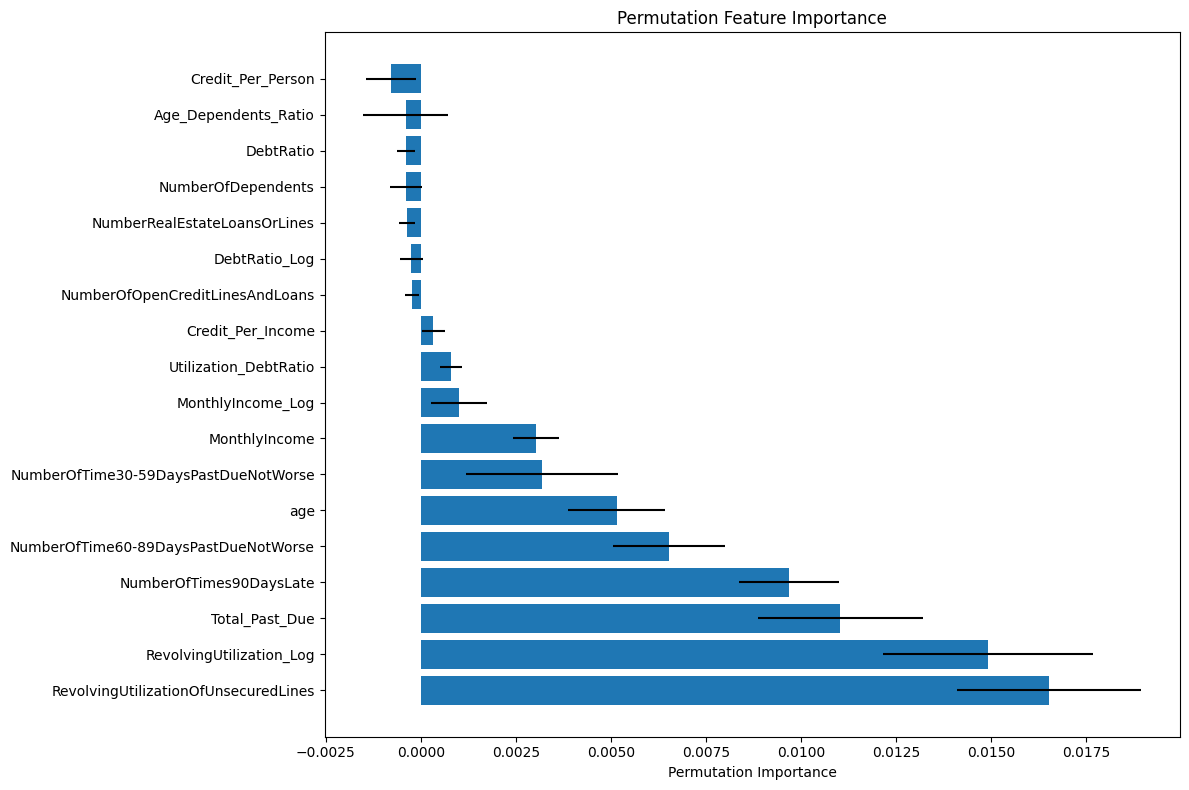

In [33]:
# 2. Permutation Importance (Model Agnostic)
def predict_proba_wrapper(X):
    return best_model.predict_proba(scaler.transform(X))

perm_importance = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
perm_df = perm_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(perm_df['Feature'], perm_df['Importance'], xerr=perm_df['Std'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

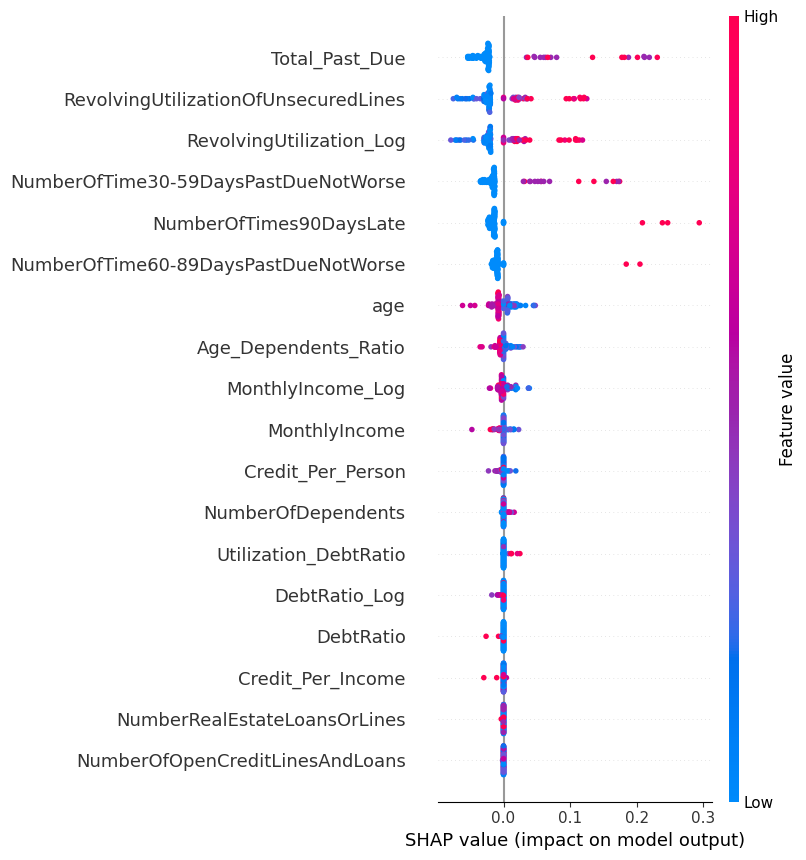

<Figure size 640x480 with 0 Axes>

In [22]:
# 3. SHAP (SHapley Additive exPlanations)
def model_predict(X):
    if isinstance(X, pd.DataFrame):
        X_scaled = scaler.transform(X)
    else:
        X_scaled = scaler.transform(X)
    return best_model.predict_proba(X_scaled)[:, 1]

X_train_summary = shap.sample(X_train, 100, random_state=42)
explainer = shap.KernelExplainer(model_predict, X_train_summary)
shap_values = explainer.shap_values(X_test.iloc[:100])

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test.iloc[:100])
plt.tight_layout()
plt.show()

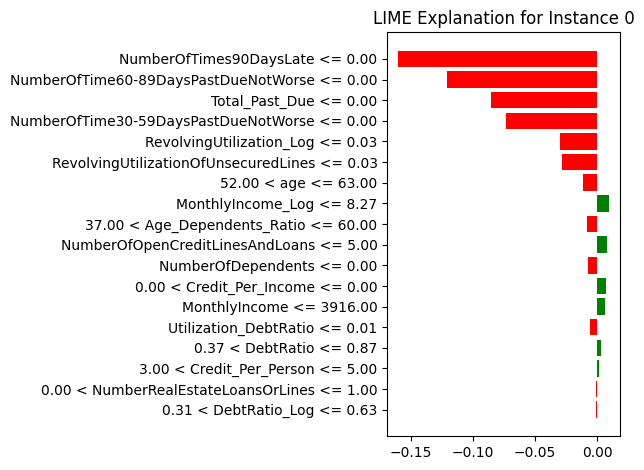

In [24]:
# 4. LIME (Local Interpretable Model-agnostic Explanations)

lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Non-Default', 'Default'],
    mode='classification'
)


sample_idx = 0
lime_exp = lime_explainer.explain_instance(
    X_test.iloc[sample_idx].values,
    lambda x: best_model.predict_proba(scaler.transform(x)),
    num_features=len(X_train.columns)
)

fig = lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {sample_idx}")
plt.tight_layout()
plt.show()
